# Stitching and normalisation

Here we demonstrate netCDF-SCM's stitching and normalisation capability with multiple ensemble members.

In [1]:
import datetime as dt
import os.path

import pymagicc
import tqdm.autonotebook as tqdman
from scmdata import ScmRun, run_append

import netcdf_scm
import netcdf_scm.io
from netcdf_scm.normalisation import get_normaliser
from netcdf_scm.stitching import get_branch_time, step_up_family_tree

import matplotlib.pyplot as plt
import seaborn as sns

<ipython-input-1-1068e7d1a33d>:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman


In [2]:
assert netcdf_scm.__version__.startswith("2.0.0")

## Crunching

Before we can stitch and normalise, the first step is to 'crunch' the raw data i.e. calculate the timeseries of interest. For this we provide a command line tool, `netcdf-scm-crunch`.

In [3]:
!netcdf-scm crunch -h

Usage: netcdf-scm crunch [OPTIONS] SRC DST CRUNCH_CONTACT

  Crunch data in ``src`` to netCDF-SCM ``.nc`` files in ``dst``.

  ``src`` is searched recursively and netcdf-scm will attempt to crunch all
  the files found. The directory structure in ``src`` will be mirrored in
  ``dst``.

  Failures and warnings are recorded and written into a text file in
  ``dst``. We recommend examining this file using a file analysis tool such
  as ``grep``. We often use the command ``grep "\|WARNING\|INFO\|ERROR <log-
  file>``.

  ``crunch_contact`` is written into the output ``.nc`` files'
  ``crunch_contact`` attribute.

Options:
  --drs [Scm|MarbleCMIP5|CMIP6Input4MIPs|CMIP6Output]
                                  Data reference syntax to use for crunching.
                                  [default: Scm]

  --regexp TEXT                   Regular expression to apply to file
                                  directory (only crunches matches). Be
                                  careful, if you 

We can crunch our test data as shown below.

In [4]:
!netcdf-scm crunch \
    ../data/raw/cmip6-output/CMIP6 \
    ../data/processed/cmip6-output \
    "zebedee.nicholls@climate-energy-college.org" \
    --regexp ".*CNRM-CM6-1.*tas.*" \
    --drs CMIP6Output \
    --regions "World" \
    --small-number-workers 8 \
    --small-threshold 40 \
    --medium-number-workers 2 \
    --small-threshold 160 \
    --force-lazy-threshold 500


18946 2020-10-08 11:20:41,304 INFO:netcdf_scm:netcdf-scm: 2.0.0rc5+12.g133c1b4.dirty
18946 2020-10-08 11:20:41,305 INFO:netcdf_scm:crunch-contact: zebedee.nicholls@climate-energy-college.org
18946 2020-10-08 11:20:41,305 INFO:netcdf_scm:source: /Users/znicholls/Documents/AGCEC/netCDF-SCM/netcdf-scm/papers/v2/data/raw/cmip6-output/CMIP6
18946 2020-10-08 11:20:41,305 INFO:netcdf_scm:destination: /Users/znicholls/Documents/AGCEC/netCDF-SCM/netcdf-scm/papers/v2/data/processed/cmip6-output/netcdf-scm-crunched
18946 2020-10-08 11:20:41,305 INFO:netcdf_scm:drs: CMIP6Output
18946 2020-10-08 11:20:41,305 INFO:netcdf_scm:regexp: .*CNRM-CM6-1.*tas.*
18946 2020-10-08 11:20:41,305 INFO:netcdf_scm:regions: World
18946 2020-10-08 11:20:41,305 INFO:netcdf_scm:force: False
18946 2020-10-08 11:20:41,305 INFO:netcdf_scm:small_number_workers: 8
18946 2020-10-08 11:20:41,305 INFO:netcdf_scm:small_threshold: 160.0
18946 2020-10-08 11:20:41,305 INFO:netcdf_scm:medium_number_workers: 2
18946 2020-10-08 11:20:

The output files can be listed as shown below.

In [5]:
!find ../data/processed/cmip6-output -type f -name '*tas*CNRM*'

../data/processed/cmip6-output/netcdf-scm-stitched/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/historical/r1i1p1f2/Amon/tas/gr/v20180917/netcdf-scm_tas_Amon_CNRM-CM6-1_historical_r1i1p1f2_gr_185001-201412.MAG
../data/processed/cmip6-output/netcdf-scm-stitched/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/historical/r3i1p1f2/Amon/tas/gr/v20190125/netcdf-scm_tas_Amon_CNRM-CM6-1_historical_r3i1p1f2_gr_185001-201412.MAG
../data/processed/cmip6-output/netcdf-scm-stitched/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/historical/r5i1p1f2/Amon/tas/gr/v20190125/netcdf-scm_tas_Amon_CNRM-CM6-1_historical_r5i1p1f2_gr_185001-201412.MAG
../data/processed/cmip6-output/netcdf-scm-stitched/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM-CM6-1/ssp245/r1i1p1f2/Amon/tas/gr/v20190219/netcdf-scm_tas_Amon_CNRM-CM6-1_ssp245_r1i1p1f2_gr_185001-210012.MAG
../data/processed/cmip6-output/netcdf-scm-stitched/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM-CM6-1/ssp245/r3i1p1f2/Amon/tas/gr/v20190410/netcdf-scm_tas_Amon_CNRM-CM6-1_ssp245_r3i1p1f2_gr_185001-210012.MAG
..

## Stitching and normalisation

We can then use netCDF-SCM to stitch and normalise these files.

In [6]:
!netcdf-scm stitch -h

Usage: netcdf-scm stitch [OPTIONS] SRC DST STITCH_CONTACT

  Stitch netCDF-SCM ``.nc`` files together and write out in the specified
  format.

  ``SRC`` is searched recursively and netcdf-scm will attempt to stitch all
  the files found. Output is written in ``DST``.

  ``STITCH_CONTACT`` is written into the header of the output files.

Options:
  --regexp TEXT                   Regular expression to apply to file
                                  directory (only stitches matches). Be
                                  careful, if you use a very copmlex regexp
                                  directory sorting can be extremely slow (see
                                  e.g. discussion at
                                  https://stackoverflow.com/a/5428712)!
                                  [default: ^(?!.*(fx)).*$]

  --prefix TEXT                   Prefix to apply to output file names (not
                                  paths).

  --out-format [mag-files|mag-files-average-year-

Note that the stitching of IPSL's G6solar data fails because it has incorrectly labelled its parent's experiment_id as CMIP, rather than ScenarioMIP (which is the MIP ssp585 belongs to).

In [7]:
!netcdf-scm stitch \
    ../data/processed/cmip6-output/netcdf-scm-crunched/CMIP6 \
    ../data/processed/cmip6-output/netcdf-scm-stitched \
    "zebedee.nicholls@climate-energy-college.org" \
    --out-format "mag-files" \
    --drs CMIP6Output \
    --regexp '^(?!.*(piControl)).*CNRM-CM6-1.*$' \
    --number-workers 8 \
    --normalise "21-yr-running-mean"

19066 2020-10-08 11:21:00,030 INFO:netcdf_scm:netcdf-scm: 2.0.0rc5+12.g133c1b4.dirty
19066 2020-10-08 11:21:00,030 INFO:netcdf_scm:stitch-contact: zebedee.nicholls@climate-energy-college.org
19066 2020-10-08 11:21:00,030 INFO:netcdf_scm:source: /Users/znicholls/Documents/AGCEC/netCDF-SCM/netcdf-scm/papers/v2/data/processed/cmip6-output/netcdf-scm-crunched/CMIP6
19066 2020-10-08 11:21:00,030 INFO:netcdf_scm:destination: /Users/znicholls/Documents/AGCEC/netCDF-SCM/netcdf-scm/papers/v2/data/processed/cmip6-output/netcdf-scm-stitched
19066 2020-10-08 11:21:00,030 INFO:netcdf_scm:regexp: ^(?!.*(piControl)).*CNRM-CM6-1.*$
19066 2020-10-08 11:21:00,030 INFO:netcdf_scm:prefix: None
19066 2020-10-08 11:21:00,030 INFO:netcdf_scm:out-format: mag-files
19066 2020-10-08 11:21:00,030 INFO:netcdf_scm:drs: CMIP6Output
19066 2020-10-08 11:21:00,030 INFO:netcdf_scm:force: False
19066 2020-10-08 11:21:00,030 INFO:netcdf_scm:number-workers: 8
19066 2020-10-08 11:21:00,030 INFO:netcdf_scm:target-units-spec

Once again, we can examine the resulting files.

In [8]:
!find ../data/processed/cmip6-output/netcdf-scm-stitched -type f -name '*CNRM-CM6-1*'

../data/processed/cmip6-output/netcdf-scm-stitched/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/historical/r1i1p1f2/Amon/tas/gr/v20180917/netcdf-scm_tas_Amon_CNRM-CM6-1_historical_r1i1p1f2_gr_185001-201412.MAG
../data/processed/cmip6-output/netcdf-scm-stitched/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/historical/r3i1p1f2/Amon/tas/gr/v20190125/netcdf-scm_tas_Amon_CNRM-CM6-1_historical_r3i1p1f2_gr_185001-201412.MAG
../data/processed/cmip6-output/netcdf-scm-stitched/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/historical/r5i1p1f2/Amon/tas/gr/v20190125/netcdf-scm_tas_Amon_CNRM-CM6-1_historical_r5i1p1f2_gr_185001-201412.MAG
../data/processed/cmip6-output/netcdf-scm-stitched/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM-CM6-1/ssp245/r1i1p1f2/Amon/tas/gr/v20190219/netcdf-scm_tas_Amon_CNRM-CM6-1_ssp245_r1i1p1f2_gr_185001-210012.MAG
../data/processed/cmip6-output/netcdf-scm-stitched/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM-CM6-1/ssp245/r3i1p1f2/Amon/tas/gr/v20190410/netcdf-scm_tas_Amon_CNRM-CM6-1_ssp245_r3i1p1f2_gr_185001-210012.MAG
..

In [9]:
def plot_normalisation(
    inpath,
    netcdf_scm_crunched_root_dir,
    region_to_plot,
    axes,
    norm_colour="tab:green",
    dashes=[(10, 5)],
    legend=True,
    drs="CMIP6Output"
):
    mag_data = netcdf_scm.io.load_mag_file(file, drs)

    return plot_normalisation_scmdf(
        mag_data.filter(region=region_to_plot),
        netcdf_scm_crunched_root_dir,
        region_to_plot,
        axes,
        norm_colour=norm_colour,
        dashes=dashes,
        legend=legend,
    )


def get_highest_valid_level_and_source_files(
    scmdata, netcdf_scm_crunched_root_dir
):
    source_files = {
        "normalisation": os.path.join(
            netcdf_scm_crunched_root_dir,
            scmdata.metadata["(normalisation) netcdf-scm crunched file"],
        )
    }

    level = "child"
    for i in range(20):
        level_key = "({})".format(level)
        try:
            source_files[level] = os.path.join(
                netcdf_scm_crunched_root_dir,
                scmdata.metadata[
                    "{} netcdf-scm crunched file".format(level_key)
                ],
            )
        except KeyError:
            break

        highest_valid_level = level
        level = (
            step_up_family_tree(level_key).replace("(", "").replace(")", "")
        )
    else:
        raise ValueError("level = {}, really?".format(level))

    return highest_valid_level, source_files


def get_shifted_normalisation(
    normalisation, branching_time, highest_level_start
):
    normalisation_shifted = normalisation.timeseries()

    normalisation_shifted.columns = normalisation_shifted.columns.map(
        lambda x: dt.datetime(
            x.year - branching_time.year + highest_level_start.year,
            x.month,
            x.day,
            x.hour,
        )
    )
    normalisation_shifted = normalisation_shifted.reset_index()
    normalisation_shifted["scenario"] = "{}-shifted".format(
        normalisation.get_unique_meta("scenario", no_duplicates=True)
    )
    normalisation_shifted = ScmRun(normalisation_shifted)

    return normalisation_shifted


def get_plot_df(src_data):
#     out = src_data.long_data()
#     out["time"] = out["time"].apply(lambda x: x.year + x.month / 12)
    out = src_data.time_mean("AC").long_data()
    out["time"] = out["time"].apply(lambda x: x.year + 0.5)

    return out


def make_plot(
    axes,
    source_data,
    source_scmdfs,
    stitched_normalised,
    region_to_plot,
    branching_time,
    highest_level,
    highest_level_start,
    norm_colour,
    dashes,
    legend,
):
    alpha = 0.7
    linewidth = 3
    sns_df = get_plot_df(
        source_data.filter(scenario="*shifted", keep=False).filter(
            region=region_to_plot,
        )
    )
    axes[0] = sns.lineplot(
        data=sns_df,
        x="time",
        y="value",
        hue="scenario",
        style="region",
        ax=axes[0],
        dashes=dashes,
        legend=legend if not legend else "brief",
        alpha=alpha,
        linewidth=linewidth,
    )
    axes[0].axvline(
        branching_time.year,
        label="branch point in raw piControl",
        alpha=0.5,
        color="gray",
    )
    if legend:
        axes[0].legend()

    axes[0].set_title("Raw data")

    sns_df = get_plot_df(
        source_data.filter(
            scenario=source_scmdfs["normalisation"].get_unique_meta(
                "scenario", no_duplicates=True
            ),
            keep=False,
        ).filter(region=region_to_plot,)
    )

    existing_handles, existing_labels = axes[1].get_legend_handles_labels()

    axes[1] = sns.lineplot(
        data=sns_df,
        x="time",
        y="value",
        hue="scenario",
        style="region",
        ax=axes[1],
        dashes=dashes,
        legend=legend if not legend else "brief",
        alpha=alpha,
        linewidth=linewidth,
    )

    tmp = stitched_normalised.filter(region=region_to_plot,).timeseries()
    tmp.index = (
        source_scmdfs["normalisation"]
        .filter(region=region_to_plot)
        .timeseries()
        .index
    )
    
    normaliser = get_normaliser(stitched_normalised.metadata["normalisation method"])
    reference_values = normaliser.get_reference_values(
        pymagicc.io.MAGICCData(tmp),
        source_scmdfs["normalisation"].filter(region=region_to_plot),
        branching_time,
    )
    norm_label = "normalisation reference values"
    norm_handle = axes[1].plot(
        reference_values.columns.map(lambda x: x.year).values.squeeze(),
        reference_values.values.squeeze(),
        label=norm_label,
        color=norm_colour,
        dashes=dashes[0],
        alpha=alpha,
        linewidth=linewidth,
    )
    axes[1].set_title("Shifted normalisation data")

    axes[1].axvline(
        highest_level_start.year,
        label="branch point in shifted piControl\n(same data just different time axis)",
        alpha=0.5,
        color="gray",
    )
    axes[1].set_xlim(
        source_scmdfs[highest_level]["year"].min() - 100,
        source_scmdfs["child"]["year"].max() + 200,
    )

    if legend:
        axes[1].legend(loc="right")
    else:
        handles = existing_handles + [norm_handle]
        labels = existing_labels + [norm_label]
        axes[1].legend(handles, labels, loc="right")

    sns_df = get_plot_df(stitched_normalised.filter(region=region_to_plot,))
    axes[2] = sns.lineplot(
        data=sns_df,
        x="time",
        y="value",
        hue="scenario",
        style="region",
        ax=axes[2],
        dashes=dashes,
        legend=legend if not legend else "brief",
        alpha=alpha,
        linewidth=linewidth,
    )
    axes[2].set_title("Stiched and normalised data")

    return axes


def plot_normalisation_scmdf(
    scmdf_in,
    netcdf_scm_crunched_root_dir,
    region_to_plot,
    axes,
    norm_colour="tab:green",
    dashes=[(10, 5)],
    legend=True,
):
    scmdf = scmdf_in.filter(region_to_plot)
    assert len(axes) == 3, "Must pass in three axes to plot on"

    (
        highest_valid_level,
        source_files,
    ) = get_highest_valid_level_and_source_files(
        scmdf, netcdf_scm_crunched_root_dir
    )
    
    source_scmdfs = {
        k: netcdf_scm.io.load_scmrun(v) for k, v in tqdman.tqdm(source_files.items())
    }

    highest_level_start = source_scmdfs[highest_valid_level]["time"].min()

    branching_time = get_branch_time(
        source_scmdfs[highest_valid_level],
        parent_path=source_files["normalisation"],
    )

    source_scmdfs["normalisation_shifted"] = get_shifted_normalisation(
        source_scmdfs["normalisation"], branching_time, highest_level_start,
    )

    source_data = run_append([v for v in source_scmdfs.values()])

    return make_plot(
        axes,
        source_data,
        source_scmdfs,
        scmdf_in,
        region_to_plot,
        branching_time,
        highest_valid_level,
        highest_level_start,
        norm_colour,
        dashes,
        legend,
    )

In [10]:
def retrieve_data(
    inpath,
    netcdf_scm_crunched_root_dir,
    region_to_plot,
    drs="CMIP6Output"
):
    mag_data = netcdf_scm.io.load_mag_file(file, drs)
    member_id = mag_data.get_unique_meta("member_id", no_duplicates=True)
    
    scmdf = mag_data.filter(region_to_plot)

    (
        highest_valid_level,
        source_files,
    ) = get_highest_valid_level_and_source_files(
        scmdf, netcdf_scm_crunched_root_dir
    )
    
    source_scmdfs = {
        k: netcdf_scm.io.load_scmrun(v) for k, v in tqdman.tqdm(source_files.items())
    }

    highest_level_start = source_scmdfs[highest_valid_level]["time"].min()

    branching_time = get_branch_time(
        source_scmdfs[highest_valid_level],
        parent_path=source_files["normalisation"],
    )

    source_scmdfs["normalisation_shifted"] = get_shifted_normalisation(
        source_scmdfs["normalisation"], branching_time, highest_level_start,
    )

    source_data = run_append([v for v in source_scmdfs.values()])
    source_data["member_id"] = member_id

    return scmdf, source_data, {member_id: branching_time}

In [11]:
# NBVAL_IGNORE_OUTPUT
netcdf_scm_crunched_root_dir = os.path.join(
    "..",
    "data",
    "processed",
    "cmip6-output",
    "netcdf-scm-crunched",
)
region_to_plot = "World"

ensemble_members_versions = (
#     ("r1i1p1f2", "v20190219"),
    ("r3i1p1f2", "v20190410"),
    ("r5i1p1f2", "v20190410"),
)

all_stitched = []
all_data = []
branch_times = {}
for em, v in ensemble_members_versions:
    file = os.path.join(
        "..",
        "data",
        "processed",
        "cmip6-output",
        "netcdf-scm-stitched",
        "CMIP6",
        "ScenarioMIP",
        "CNRM-CERFACS",
        "CNRM-CM6-1",
        "ssp245",
        em,
        "Amon",
        "tas",
        "gr",
        v,
        f"netcdf-scm_tas_Amon_CNRM-CM6-1_ssp245_{em}_gr_185001-210012.MAG"
    )
    
    stitched, data, branch_time = retrieve_data(
        file,
        netcdf_scm_crunched_root_dir,
        region_to_plot,
        drs="CMIP6Output"
    )
    branch_times = {**branch_times, **branch_time}
    all_stitched.append(stitched)
    all_data.append(data)

all_stitched = run_append(all_stitched)
all_data = run_append(all_data, duplicate_msg=False)
# plot_normalisation(
#     file,
#     netcdf_scm_crunched_root_dir,
#     "World",
#     axes,
#     norm_colour="tab:pink",
#     dashes=[(None, None)],
#     legend=True,
# )

# for i, ax in enumerate(axes):
#     if i == 0:
#         ax.set_xlim([1800, 2300])
#     if i == 1:
#         ax.set_xlim([1800, 2150])
#     if i == 2:
#         ax.set_xlim([1850, 2100])
        
#     ax.tick_params(axis='both', which='major', length=10, width=2, pad=6, labelsize=14)
#     [ab.set_linewidth(2) for ab in ax.spines.values()]
    
# plt.tight_layout()
# # plt.savefig("stitching-and-normalisation.pdf", transparent=True)

In [12]:
all_data = all_data.filter(scenario="piControl*", member_id="r3i1p1f2", keep=False)

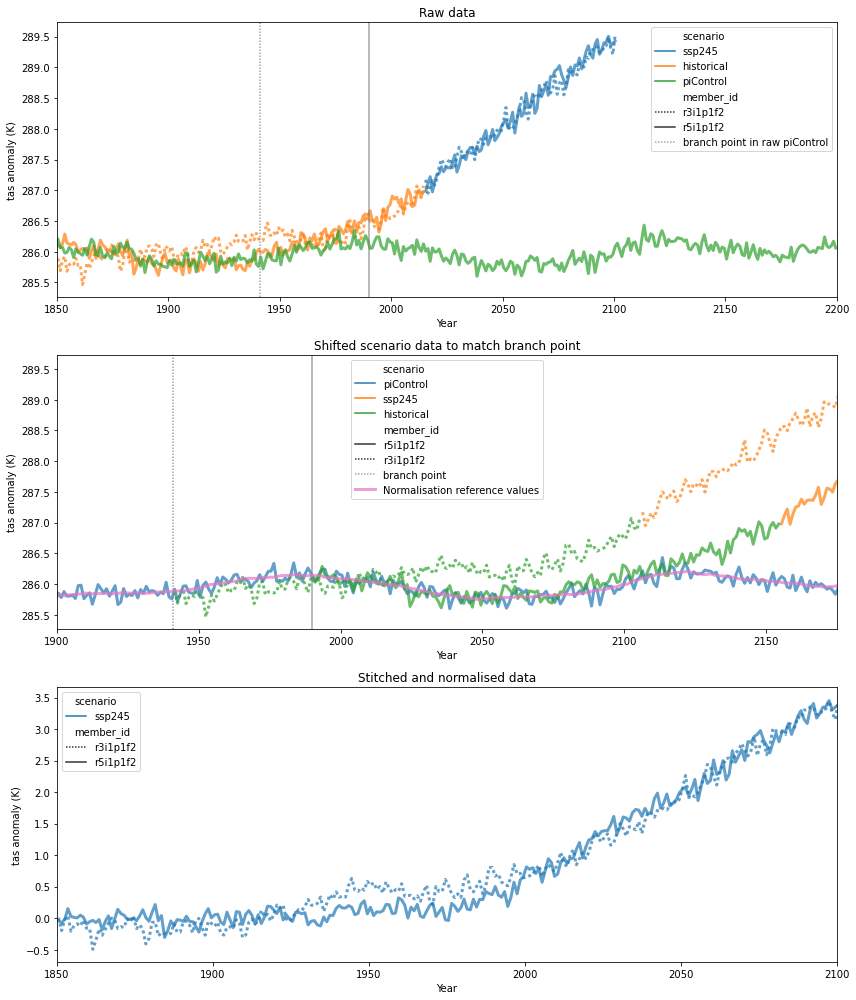

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 14))
axes = axes.flatten()

linewidth = 3
alpha = 0.7
dashes = {"r1i1p1f2": "", "r3i1p1f2": (5, 3), "r5i1p1f2": (1, 1)}
dashes = {"r1i1p1f2": "", "r3i1p1f2": "", "r5i1p1f2": (1, 1)}
dashes = {"r1i1p1f2": "", "r5i1p1f2": "", "r3i1p1f2": (1, 1)}

sns.lineplot(
    data=get_plot_df(all_data.filter(scenario="*shifted", keep=False)),
    x="time", 
    y="value",
    hue="scenario",
    style="member_id",
    dashes=dashes,
    ax=axes[0],
    legend="brief",
    alpha=alpha,
    linewidth=linewidth,
)
for i, (k, bt) in enumerate(branch_times.items()):
    if i < 1:
        label = "branch point in raw piControl"
    else:
        label = None
        
    axes[0].axvline(
        bt.year, 
        color="tab:gray", 
        alpha=alpha, 
        label=label, 
        dashes=dashes[k],
    )

axes[0].legend()
axes[0].set_title("Raw data")
axes[0].set_xlim([1850, 2200])

all_data_shifted = []
all_data_shifted.append(all_data.filter(scenario="piControl"))
for em in all_data.filter(scenario="pi*", keep=False).groupby("member_id"):
   
    member_id = em.get_unique_meta("member_id", no_duplicates=True)
    branch_time = branch_times[member_id]
    shift = branch_time.year - 1850
    
    scen_dat = em.filter(scenario="pi*", keep=False).timeseries()
    scen_dat.columns = scen_dat.columns.map(lambda x: dt.datetime(x.year + shift, x.month, x.day, x.hour))
    scen_dat = ScmRun(scen_dat)
    
    all_data_shifted.append(scen_dat)
    
all_data_shifted = run_append(all_data_shifted)

sns.lineplot(
    data=get_plot_df(all_data_shifted),
    x="time", 
    y="value",
    hue="scenario",
    style="member_id",
    dashes=dashes,
    ax=axes[1],
    legend="brief",
    alpha=alpha,
    linewidth=linewidth,
)
for i, (k, bt) in enumerate(branch_times.items()):
    if i < 1:
        label = "branch point"
    else:
        label = None
        
    axes[1].axvline(
        bt.year, 
        color="tab:gray", 
        alpha=alpha, 
        label=label, 
        dashes=dashes[k],
    )
    
norm_values = (
    all_data_shifted
    .filter(scenario="piControl")
    .time_mean("AC")
    .timeseries()
    .rolling(window=21, axis="columns", center=True)
    .mean()
    .dropna(axis="columns")
)
axes[1].plot(
    norm_values.columns.map(lambda x: x.year).values.squeeze(),
    norm_values.values.squeeze(),
    alpha=alpha, 
    linewidth=3,
    color="tab:pink",
    label="Normalisation reference values"
)
axes[1].set_title("Shifted scenario data to match branch point")
axes[1].set_xlim([1900, 2175])
axes[1].legend()

sns.lineplot(
    data=get_plot_df(all_stitched),
    x="time", 
    y="value",
    hue="scenario",
    style="member_id",
    dashes=dashes,
    ax=axes[2],
    legend="brief",
    alpha=alpha,
    linewidth=linewidth,
)
axes[2].set_xlim([1850, 2100])
axes[2].set_title("Stitched and normalised data")

for ax in axes:
    ax.set_xlabel("Year")
    ax.set_ylabel("tas anomaly (K)")

plt.tight_layout()
plt.savefig("stitching-and-normalisation-multiple-ensemble-members.pdf", transparent=True)